## 1. Variational Autoencoder

1) Import Libraries

In [1]:
# AE.ipynb
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import os 

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2) CUDA Setting

In [2]:
# CUDA setting
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"CUDA GPU : {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')

CUDA GPU : NVIDIA GeForce RTX 4070 Ti SUPER


3) Dataset Download & Parse

In [4]:
# Dataset download (MNIST)

BATCH_SIZE = 512

train_data = datasets.MNIST('./1. Autoencoder/data', train=True, download=True, transform=transforms.ToTensor())
test_data =  datasets.MNIST('./1. Autoencoder/data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_loader =  torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

4) Model Archtecture & Structure

In [7]:
# Model architecture

class VAE(nn.Module):
    def __init__(self, latent_dimension = 16):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), # 1x28x28 -> 32x14x14
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), # 32x14x14 -> 64x7x7
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7), # 64x7x7 -> 64x1x1
            nn.ReLU(),
        )

        self.latent_mean = nn.Sequential(
            nn.Linear(in_features=64, out_features=latent_dimension, bias=True),
        )

        self.latent_logvar = nn.Sequential(
            nn.Linear(in_features=64, out_features=latent_dimension, bias=True),
        )

        self.latent_dec = nn.Sequential(
            nn.Linear(in_features=latent_dimension, out_features=64),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mean, logvar):
        eps = torch.randn_like(logvar).to(device)
        std = torch.exp(logvar * 0.5)

        return mean + std * eps
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, 64) # reshape

        means = self.latent_mean(x) # BATCH, latent_dimension
        logvars = self.latent_logvar(x)

        latent_vector = self.reparameterize(means, logvars)

        recon_x = self.latent_dec(latent_vector)
        recon_x = recon_x.view(-1, 64, 1, 1)
        recon_x = self.decoder(recon_x)
                
        return recon_x, latent_vector, means, logvars

5) Training defined model (dimension = 16)

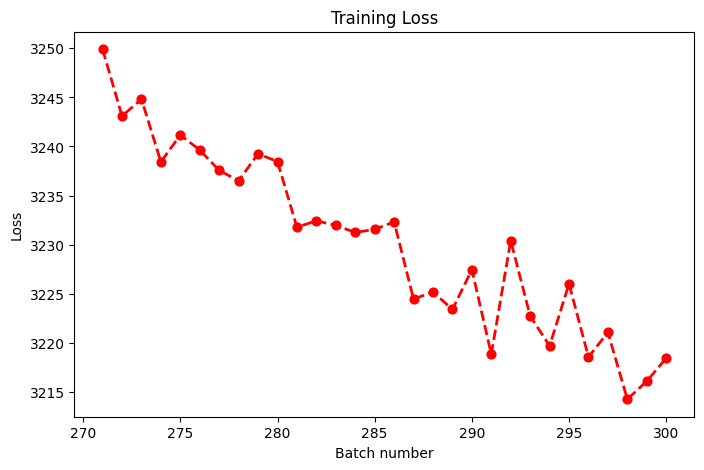

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [08:51<00:00,  1.77s/it]


In [11]:
# Model Training
from IPython import display

model = VAE().to(device)

epoch = 300

learning_rate = 1E-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = list()

def loss_fn(x, pred, mu, logvar):
    recon_loss = F.mse_loss(pred, x, reduction='sum')
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kld

for epoch_idx in trange(epoch):
    model.train()

    running_loss = 0.0
    total_batches = 0

    for (x_train, _) in train_loader:
        x_train = x_train.to(device)
        output, __, mean, logvar = model(x_train)
        
        loss = loss_fn(x_train, output, mean, logvar)
        running_loss += loss.item()
        total_batches += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(running_loss / total_batches)

    display.clear_output(wait=True)
    plt.figure(figsize=(8, 5))

    xrange = [i for i in range(1, epoch_idx+2)]
    if len(xrange) > 30:
        xrange = xrange[-30:]
        yrange = losses[xrange[0]-1:xrange[-1]]
    else:
        yrange = losses[:]
    
    plt.plot(xrange,yrange, linestyle='--', linewidth=2, c='r')
    plt.scatter(xrange, yrange, c='red', s=40)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

6) Visualization of my model

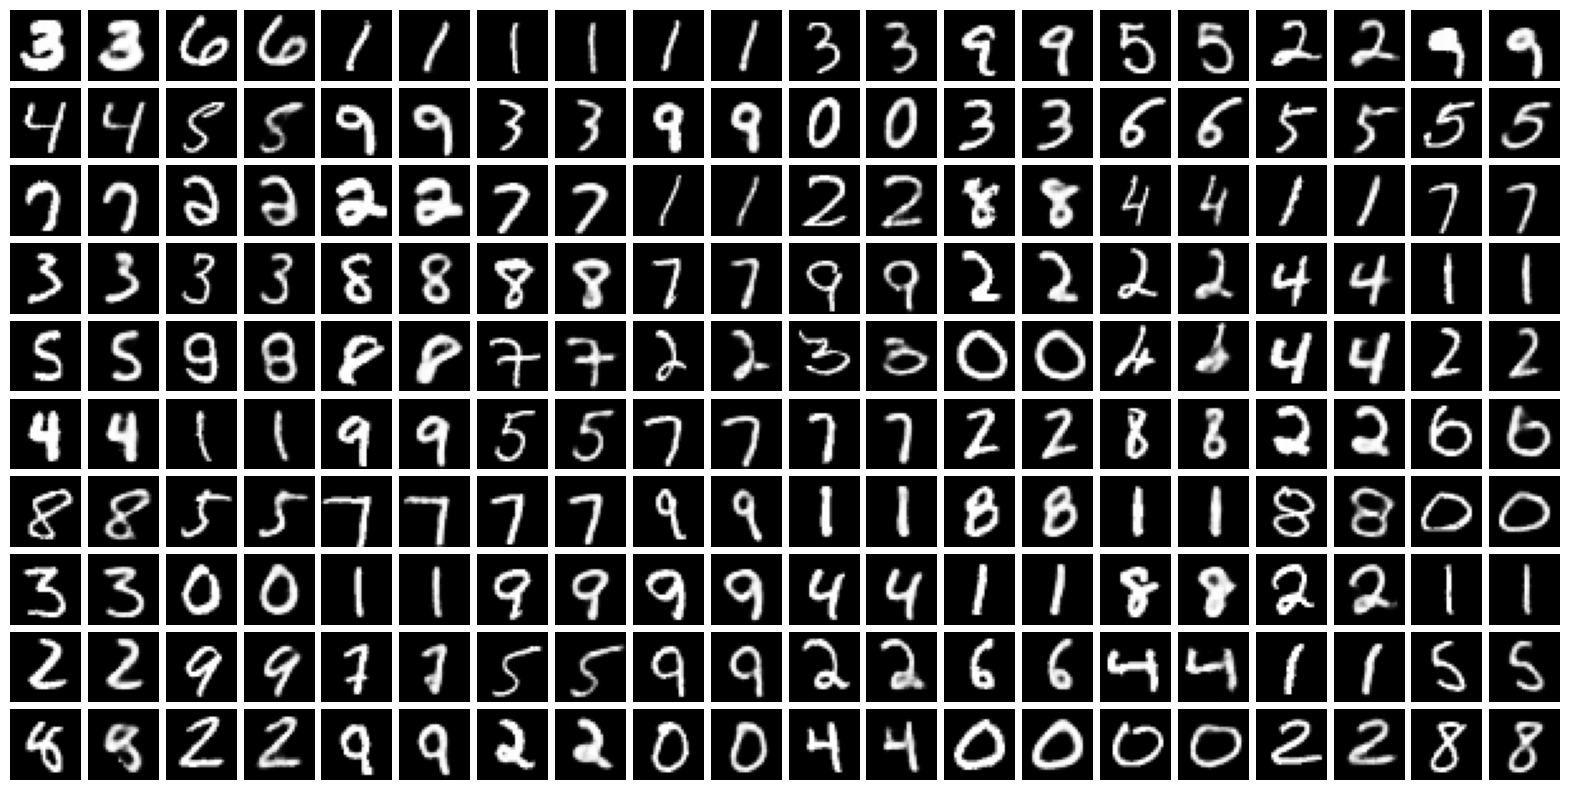

In [21]:
import matplotlib.pyplot as plt
import torch

start_idx = 200
num_pairs = 100
pairs_per_row = 10

# 전체 figure 크기를 조정하여 빈 공간을 줄입니다.
plt.figure(figsize=(20, 10))

for i in range(num_pairs):
    row = i // pairs_per_row
    col = i % pairs_per_row

    # Original Image
    plt.subplot(10, 20, 2 * col + 1 + 20 * row)
    data = test_data[start_idx + i][0]
    img = data.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(10, 20, 2 * col + 2 + 20 * row)
    with torch.no_grad():
        reconstructed_images, _, __, ___ = model(data.unsqueeze(0).to(device))
    reconstructed_images = reconstructed_images.cpu()
    plt.imshow(reconstructed_images.squeeze().reshape(28, 28), cmap='gray')
    plt.axis('off')

# 서브플롯 간의 간격을 조정합니다.
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


7) Saving Model Weights

In [33]:
print(f"Result loss : {losses[-1]}")
torch.save(model, "./VAE_MNIST.pt")

Result loss : 3218.4372475834216


## 2. 2D Modeling (decomposition)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 453.16it/s]


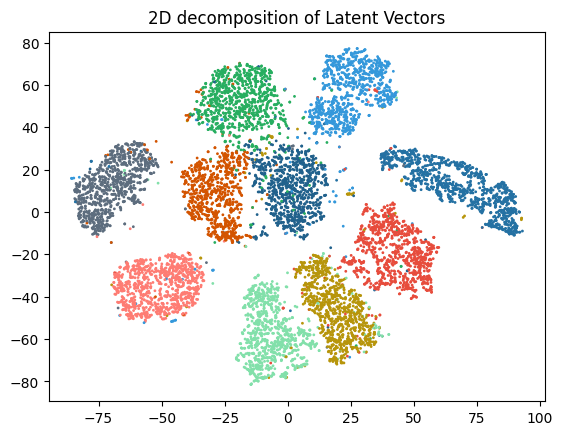

In [36]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

model = torch.load("./VAE_MNIST.pt", map_location=device)
model.eval()

latent_vectors = []
label = []
colors = ['#fe7c73', '#2471A3', '#3498DB', '#27AE60', '#82E0AA', '#D35400', '#5D6D7E', '#E74C3C', '#21618C', '#B7950B', '#46C7C7', '#00B9FF']

for (X, y) in tqdm(test_data):
    with torch.no_grad():
        _, __, latent_x, ___ = model(X.to(device))
        latent_vectors.append(latent_x.reshape(16).cpu().numpy())
    label.append(y)

color_labeled = [colors[label[i]] for i in range(len(label))]
all_latent_vectors = np.vstack(latent_vectors)

# decomposition_model = PCA(n_components=2) # Not that good performance..
decomposition_model = TSNE(n_components=2)
latent_2d = decomposition_model.fit_transform(all_latent_vectors)

plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=1, c = color_labeled)
plt.title('2D decomposition of Latent Vectors')
plt.show()

## 3. What if latent dimension is 2d?


1) Model Training

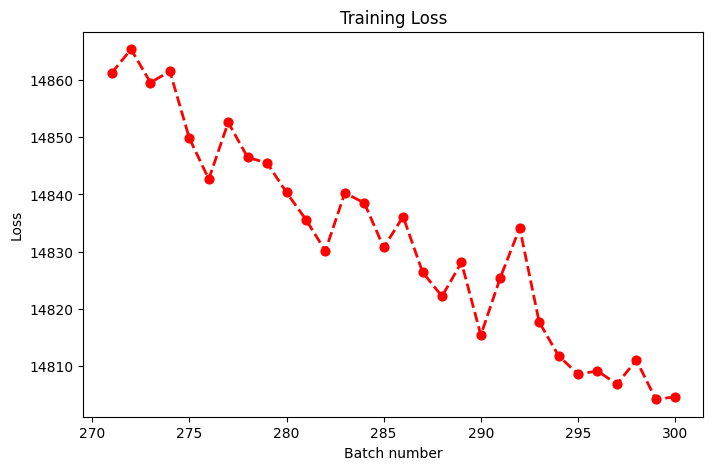

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [09:08<00:00,  1.83s/it]


In [50]:
# Model Training
from IPython import display

model = VAE(latent_dimension=2).to(device)

epoch = 300

learning_rate = 3E-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = list()

def loss_fn(x, pred, mu, logvar):
    recon_loss = F.mse_loss(pred, x, reduction='sum')
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kld

for epoch_idx in trange(epoch):
    model.train()

    running_loss = 0.0
    total_batches = 0

    for (x_train, _) in train_loader:
        x_train = x_train.to(device)
        output, __, mean, logvar = model(x_train)
        
        loss = loss_fn(x_train, output, mean, logvar)
        running_loss += loss.item()
        total_batches += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(running_loss / total_batches)

    display.clear_output(wait=True)
    plt.figure(figsize=(8, 5))

    xrange = [i for i in range(1, epoch_idx+2)]
    if len(xrange) > 30:
        xrange = xrange[-30:]
        yrange = losses[xrange[0]-1:xrange[-1]]
    else:
        yrange = losses[:]
    
    plt.plot(xrange,yrange, linestyle='--', linewidth=2, c='r')
    plt.scatter(xrange, yrange, c='red', s=40)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

2) Visualization

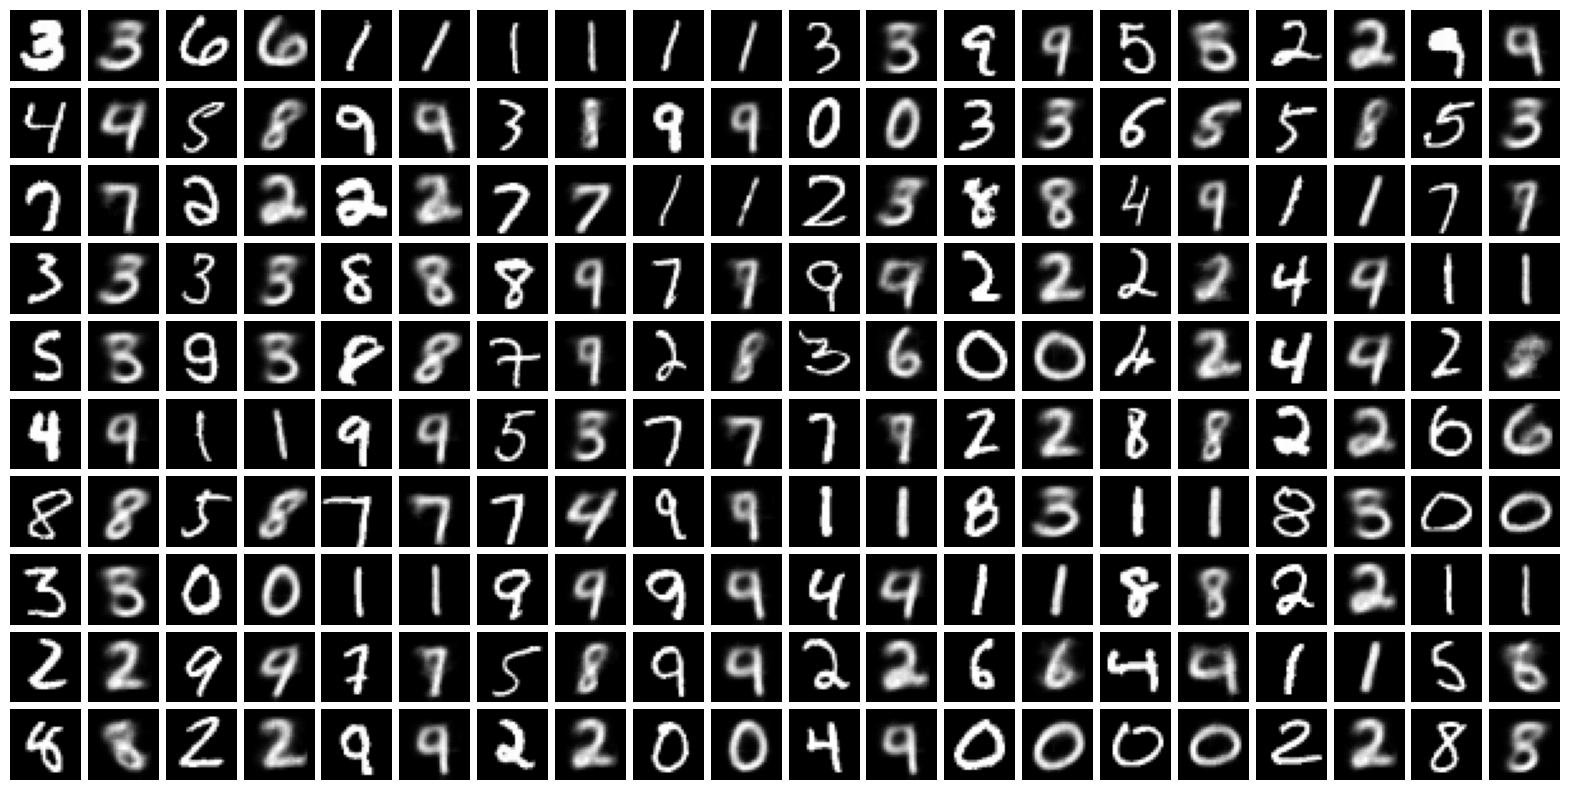

In [51]:
import matplotlib.pyplot as plt
import torch

start_idx = 200
num_pairs = 100
pairs_per_row = 10

# 전체 figure 크기를 조정하여 빈 공간을 줄입니다.
plt.figure(figsize=(20, 10))

for i in range(num_pairs):
    row = i // pairs_per_row
    col = i % pairs_per_row

    # Original Image
    plt.subplot(10, 20, 2 * col + 1 + 20 * row)
    data = test_data[start_idx + i][0]
    img = data.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(10, 20, 2 * col + 2 + 20 * row)
    with torch.no_grad():
        reconstructed_images, _, __, ___ = model(data.unsqueeze(0).to(device))
    reconstructed_images = reconstructed_images.cpu()
    plt.imshow(reconstructed_images.squeeze().reshape(28, 28), cmap='gray')
    plt.axis('off')

# 서브플롯 간의 간격을 조정합니다.
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

torch.save(model, './VAE_MNIST_2d.pt')


3) Visualization in 2d latent space

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.61it/s]


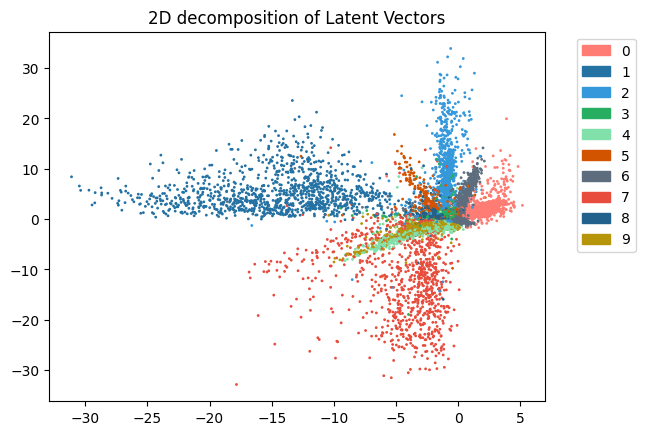

In [56]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

model = torch.load("./VAE_MNIST_2d.pt", map_location=device)
model.eval()

latent_vectors = []
label = []
colors = ['#fe7c73', '#2471A3', '#3498DB', '#27AE60', '#82E0AA', '#D35400', '#5D6D7E', '#E74C3C', '#21618C', '#B7950B']

for (X, y) in tqdm(test_data):
    with torch.no_grad():
        _, __, latent_x, ___ = model(X.to(device))
        latent_vectors.append(latent_x.reshape(2).cpu().numpy())
    label.append(y)

color_labeled = [colors[label[i]] for i in range(len(label))]
all_latent_vectors = np.vstack(latent_vectors)

plt.scatter(all_latent_vectors[:, 0], all_latent_vectors[:, 1], s=1, c = color_labeled)

patches = [mpatches.Patch(color=colors[i], label=f'{i}') for i in range(len(colors))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')\

plt.title('2D decomposition of Latent Vectors')
plt.show()

The Result of VAE is not that good in 2d space, but when the dimension is enough, It overcomes the AE itself.

Moreover, the VAE model is based in decoder, so we could make another n labeled pictures using decoder. 